# `pymc_experimental.statespace` State Space Modeling

Exploring some of the functionality recently released in `pymc-experimental` for State Space Modeling. API looks similar to the `statsmodels` `MLEModel` stuff and I think it's by the same person. (jessegrabowski)

Similar idea to `statsmodels` except some knowledge of `pytensor` is needed for slotting parameters into matrices (JAX not available).

Already has some helpers like `BayesianSARIMA` and it has an interesting API where structural components are added together to form a model:

Like:

```python
ll = st.LevelTrendComponent(order=2)
monthly_season = st.TimeSeasonality(name="monthly_seasonal", season_length=12, innovations=False)
measurement_error = st.MeasurementError(name="obs")

param_dict = {
    "initial_trend": np.zeros(
        2,
    ),
    "monthly_seasonal_coefs": rng.normal(size=11),
    "sigma_trend": np.array([0.25, 0.01]),
    "sigma_obs": np.array([0.1]),
}

mod = ll + monthly_season + measurement_error

```

Which is really cool!

On with the example:

In [6]:
%matplotlib inline
import sys

sys.path.append("..")

import jax

jax.config.update("jax_platform_name", "cpu")

import numpyro

numpyro.set_host_device_count(4)

import pymc as pm
import pytensor
from pytensor import tensor as pt

import arviz as az
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import pymc_experimental.statespace as pmss

config = {
    "figure.figsize": [12.0, 4.0],
    "figure.dpi": 72.0 * 2,
    "figure.facecolor": "w",
    "figure.constrained_layout.use": True,
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

Generate fake data

In [9]:
seed = sum(map(ord, "statespace arima"))
rng = np.random.default_rng(seed)

AR_params = [0.8, 0.0]
MA_params = [-0.5]

# Initial state
x0 = np.r_[[0.0], [0.0]]

# Hidden state transition matrix
T = np.array([[AR_params[0], 1.0], [AR_params[1], 0.0]])

# Hidden state noise coefficients
R = np.array([[1.0], [MA_params[0]]])

# Hidden state covaraince matrix
Q = np.array([[0.8]])

# Observation matrix
Z = np.array([[1.0, 0.0]])

# Observation noise covariance
H = np.array([[0.0]])

timesteps = 100
data = np.zeros(timesteps)
hidden_states = np.zeros((timesteps, 2))
hidden_states[0, :] = x0

innovations = rng.multivariate_normal(mean=np.array([0.0]), cov=Q, size=timesteps)

for t in range(1, timesteps):
    hidden_states[t] = T @ hidden_states[t - 1, :] + R @ np.atleast_1d(innovations[t])
    data[t] = Z @ hidden_states[t]

fake_dates = pd.date_range("2010-01-01", freq="MS", periods=data.shape[0])
df = pd.DataFrame(data, columns=["state"], index=fake_dates)

/var/folders/29/f5j1jzy53gb1vyk06d20mz080000gq/T/ipykernel_87049/4180522369.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[t] = Z @ hidden_states[t]


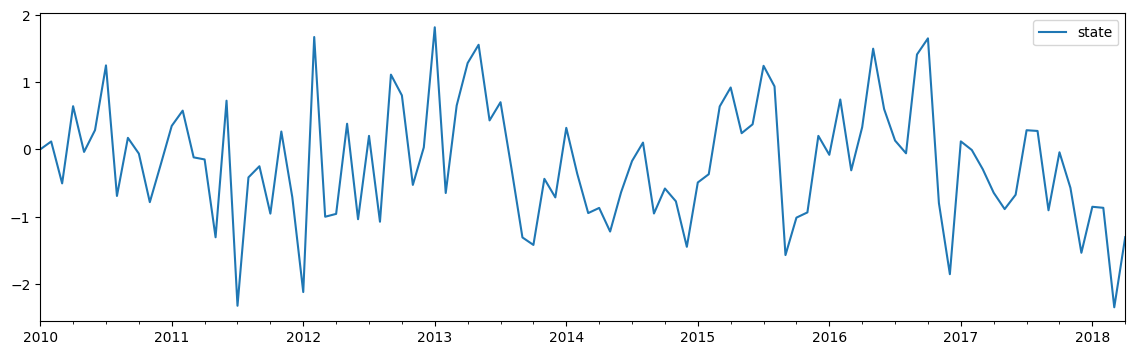

In [10]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
df.plot(ax=ax)
plt.show()

In [11]:
mod = sm.tsa.SARIMAX(endog=data, order=(1, 0, 1))
res = mod.fit(disp=0)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -128.446
Date:                Thu, 21 Sep 2023   AIC                            262.892
Time:                        12:48:29   BIC                            270.708
Sample:                             0   HQIC                           266.055
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8077      0.174      4.632      0.000       0.466       1.150
ma.L1         -0.6162      0.231     -2.670      0.008      -1.069      -0.164
sigma2         0.7630      0.109      6.990      0.000       0.549       0.977
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.84   Prob(JB):                         0.99
Heteroskedasticity (H):               0.97   Skew:                            -0.03
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# pymc

First specify the model:

In [12]:
# Step 0. Initialize the pymc state space object
ss_mod = pmss.BayesianSARIMA(order=(1, 0, 1), verbose=True)
ss_mod.state_names
# ss_mod.coords

The following parameters should be assigned priors inside a PyMC model block: 
	ar_params -- shape: (1,), constraints: None, dims: ('ar_lag',)
	ma_params -- shape: (1,), constraints: None, dims: ('ma_lag',)
	sigma_state -- shape: (1,), constraints: Positive, dims: ('observed_state',)


['data', 'state_1']

Model Specification:

In [13]:
# Step 1. Specify prior distributions using `pymc` model context

with pm.Model(coords=ss_mod.coords) as arma_model:
    state_sigmas = pm.Gamma("sigma_state", alpha=10, beta=2, dims=ss_mod.param_dims["sigma_state"])
    rho = pm.Beta("ar_params", alpha=5, beta=1, dims=ss_mod.param_dims["ar_params"])
    theta = pm.Normal("ma_params", mu=0.0, sigma=0.5, dims=ss_mod.param_dims["ma_params"])

    ss_mod.build_statespace_graph(df, mode="JAX")
    prior = pm.sample_prior_predictive(compile_kwargs={"mode": "JAX"})

/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AB3D3220>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AB3D3140>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AB3D3060>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AB3D2F80>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [ar_params, ma_params, obs, sigma_state]


## Prior Predictive checks with `.sample_unconditional_prior()`

In [14]:
unconditional_prior = ss_mod.sample_unconditional_prior(prior)

/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AD8CC660>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [prior_combined]


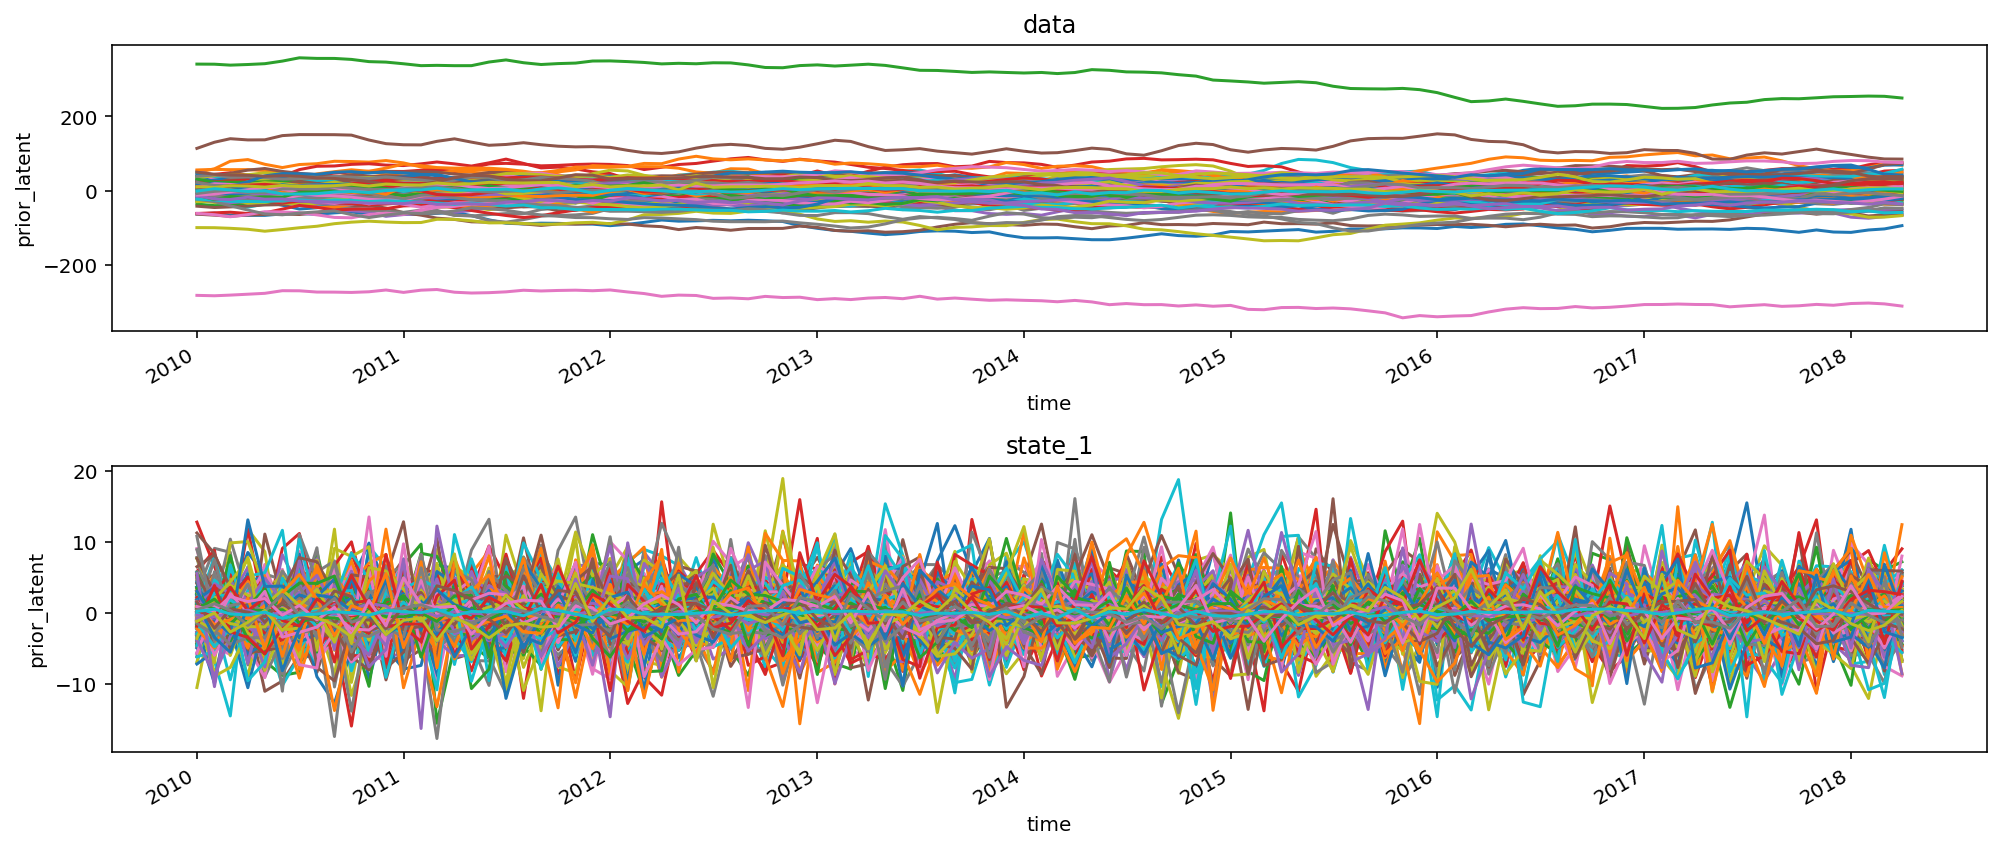

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, state) in enumerate(zip(fig.axes, ss_mod.state_names)):
    unconditional_prior.prior_latent.sel(state=state).stack(sample=["chain", "draw"]).plot.line(
        x="time", ax=axis, add_legend=False
    )
    axis.set(title=state)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

In [16]:
# Conditional
conditional_prior = ss_mod.sample_conditional_prior(prior)

/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AC64E340>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AC8E2EA0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AC64C2E0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AC9265E0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AC64DA80>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AC64C900>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_prior, filtered_prior_observed, predicted_prior, predicted_prior_observed, smoothed_prior, smoothed_prior_observed]


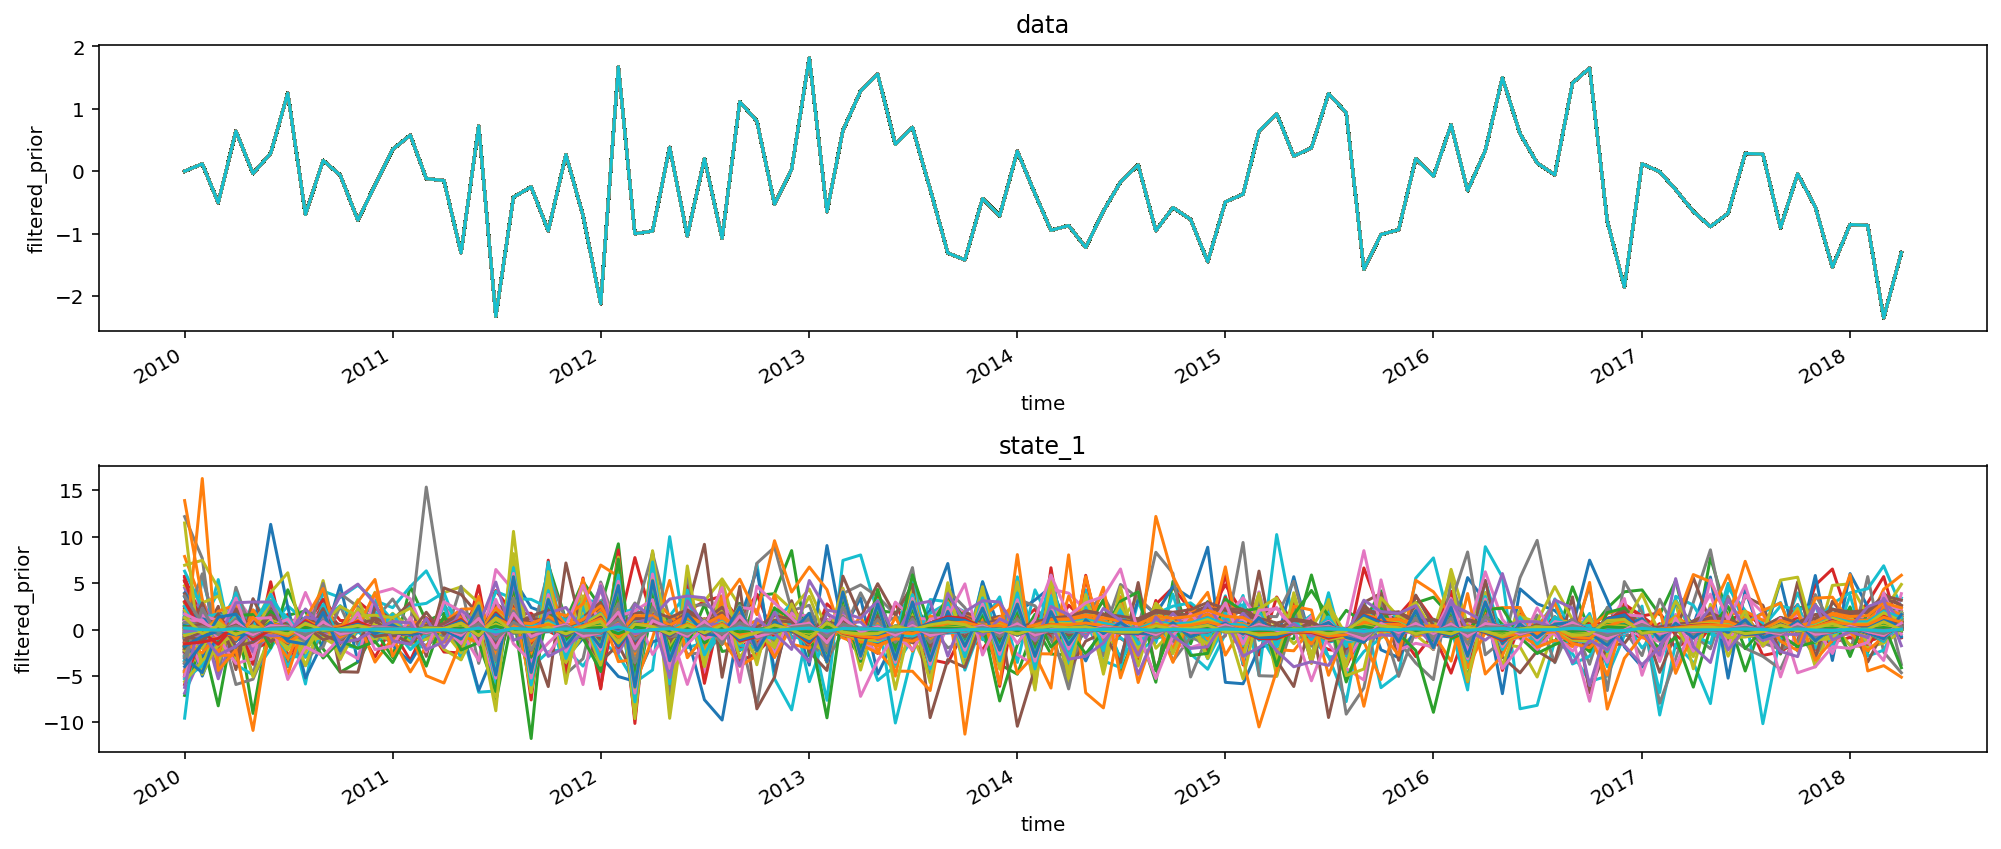

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
for idx, (axis, state) in enumerate(zip(fig.axes, ss_mod.state_names)):
    conditional_prior.filtered_prior.sel(state=state).stack(sample=["chain", "draw"]).plot.line(
        x="time", ax=axis, add_legend=False
    )
    axis.set(title=state)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

## Fitting the model

In [18]:
# Press the `pymc` inference button
with arma_model:
    idata = pm.sample(nuts_sampler="numpyro")

Compiling...
Compilation time =  0:00:04.663100
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:13.352795
Transforming variables...
Transformation time =  0:00:03.775270


Plot the parameter estimates using arviz

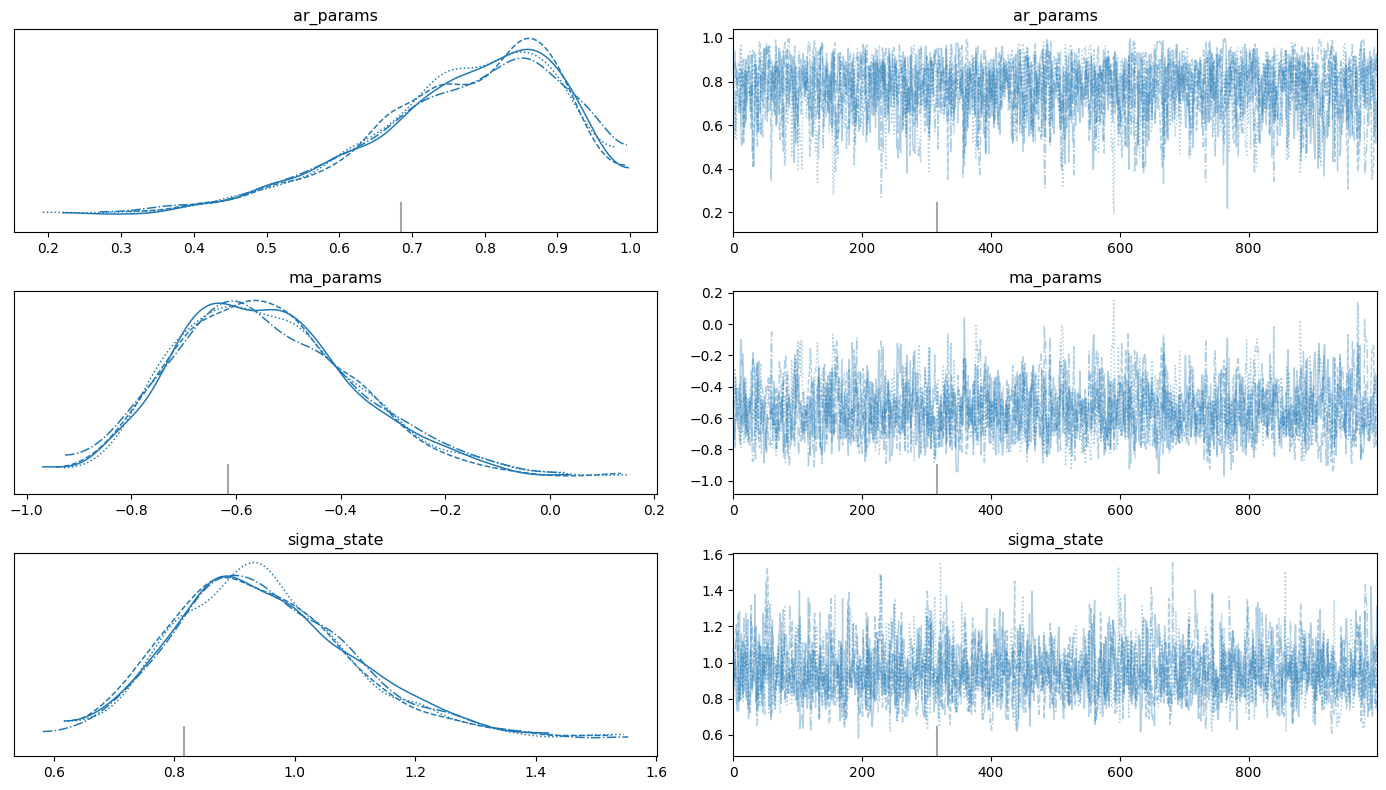

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8))
az.plot_trace(idata, var_names=ss_mod.param_names, axes=ax)
fig.tight_layout()
plt.show()

Plotting the parameter estimates against true values

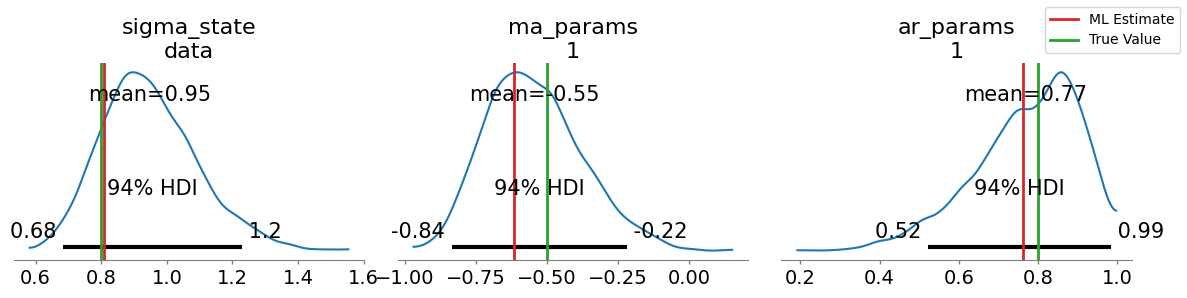

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
az.plot_posterior(idata, var_names=["sigma_state", "ma_params", "ar_params"], ax=ax)
ax[0].axvline(res.params[0], color="tab:red", lw=2, label="ML Estimate")
ax[1].axvline(res.params[1], color="tab:red", lw=2)
ax[2].axvline(res.params[2], color="tab:red", lw=2)

ax[0].axvline(0.8, color="tab:green", lw=2, label="True Value")
ax[1].axvline(-0.5, color="tab:green", lw=2)
ax[2].axvline(0.8, color="tab:green", lw=2)


fig.set(facecolor="white")
fig.tight_layout()
fig.legend()
plt.show()

# Posterior Predictive

In [21]:
unconditional_post = ss_mod.sample_unconditional_posterior(
    idata, steps=100, use_data_time_dim=False
)
post = az.extract(unconditional_post, "posterior_predictive")

/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2A8165C40>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [posterior_combined]


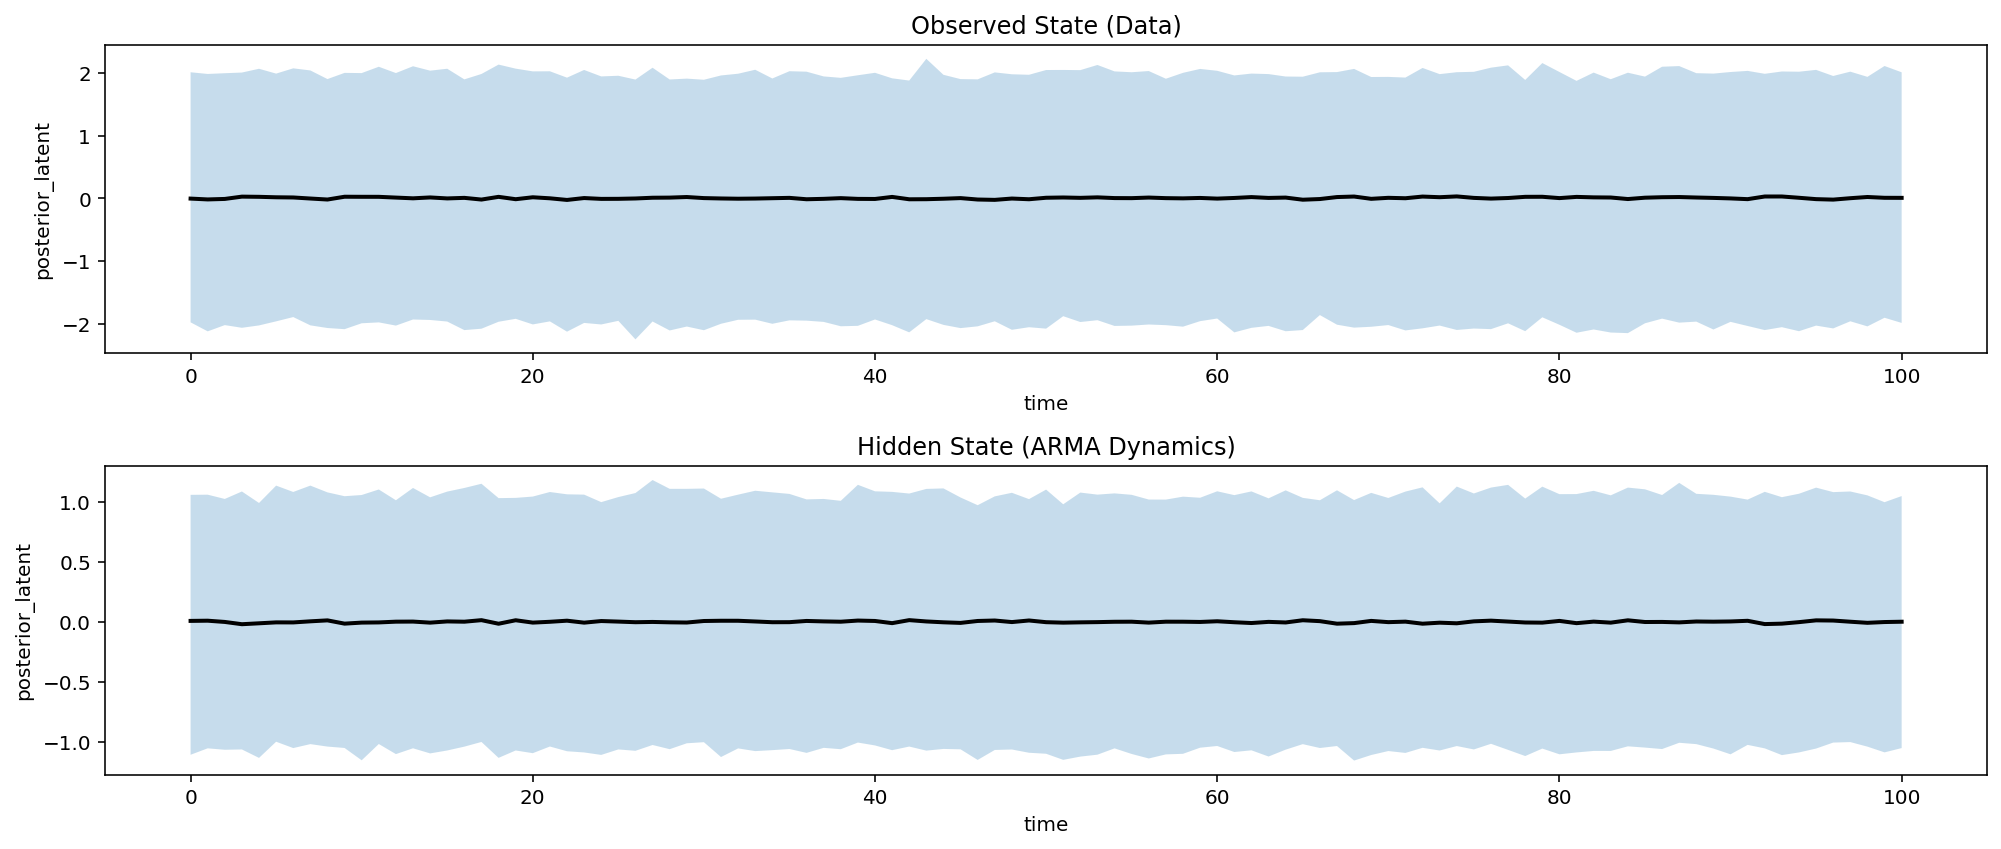

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
hdi = az.hdi(unconditional_post.posterior_latent)

for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Data)", "Hidden State (ARMA Dynamics)"])
):
    post.isel(state=idx).mean(dim="sample").posterior_latent.plot.line(
        x="time", ax=axis, color="k", lw=2, add_legend=False
    )
    axis.fill_between(
        hdi.coords["time"], *hdi.isel(state=idx).posterior_latent.values.T, alpha=0.25
    )
    axis.set(title=name)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

### Conditional

In [23]:
post_pred = ss_mod.sample_conditional_posterior(idata)

/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2A833F760>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AD64CE40>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2A833D1C0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2B2D59380>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2A833FA00>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2A833F680>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


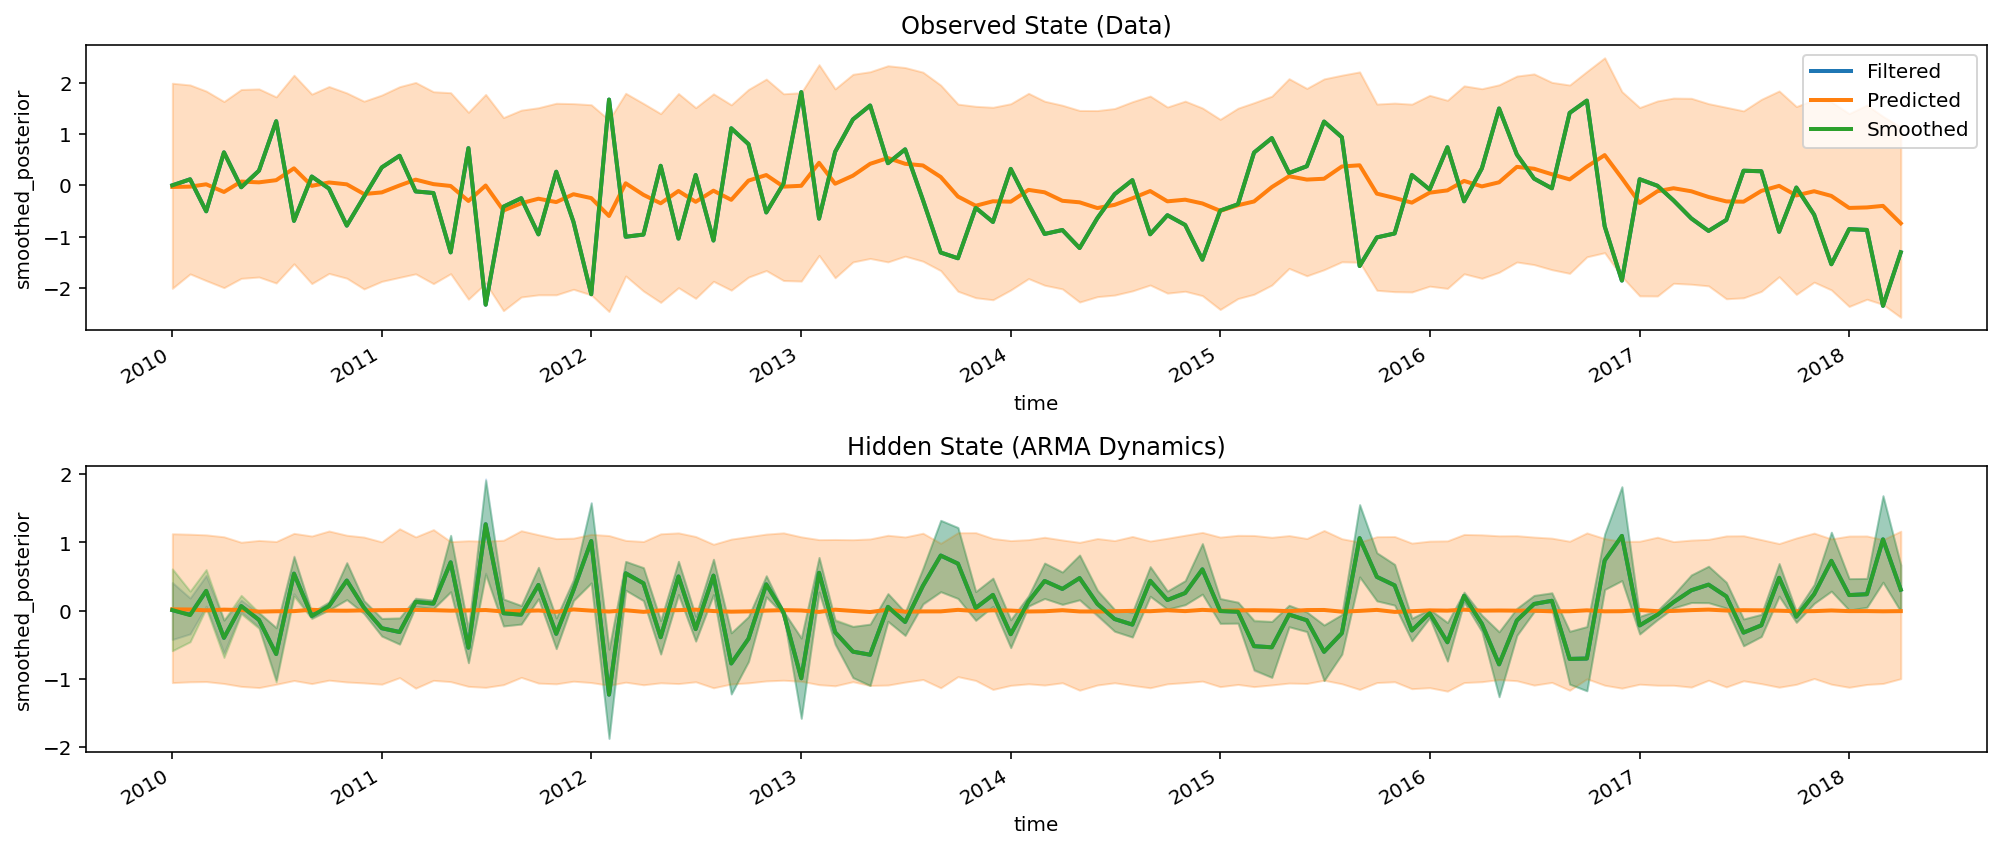

In [24]:
# Plot posterior predictive
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
post = az.extract(post_pred, "posterior_predictive")
colors = ["tab:" + c for c in ["blue", "orange", "green"]]

for filter_output, color in zip(["filtered", "predicted", "smoothed"], colors):
    hdi = az.hdi(post_pred)[f"{filter_output}_posterior"]
    for idx, (axis, name) in enumerate(
        zip(fig.axes, ["Observed State (Data)", "Hidden State (ARMA Dynamics)"])
    ):
        post[f"{filter_output}_posterior"].isel(state=idx).mean(dim="sample").plot.line(
            x="time", ax=axis, lw=2, add_legend=False, label=filter_output.title(), color=color
        )
        axis.fill_between(
            hdi.coords["time"], *hdi.isel(state=idx).values.T, alpha=0.25, color=color
        )
        axis.set(title=name)

ax[0].legend()
fig.set_facecolor("w")
fig.tight_layout()
plt.show()

## Forecasting

In [25]:
def plot_forecast(df, forecast):
    fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
    ax.plot(df.index, df.values, label="Data")

    hdi_forecast = az.hdi(idata_forecast).forecast_observed

    forecast.mean(dim="sample").forecast_observed.isel(observed_state=0).plot.line(
        x="time", label="Forecast", add_legend=False
    )
    ax.fill_between(
        forecast.coords["time"].values,
        *hdi_forecast.isel(observed_state=0).values.T,
        alpha=0.25,
        color="tab:orange",
    )

    ax.legend()
    plt.show()

/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2B04D8C80>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


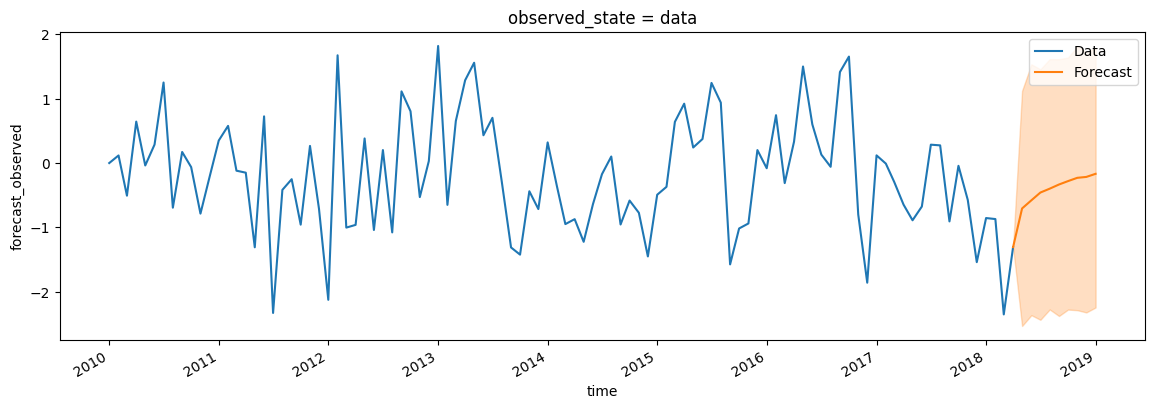

In [26]:
idata_forecast = ss_mod.forecast(idata, start=df.index[-1], periods=10)
forecast = idata_forecast.stack(sample=["chain", "draw"])
plot_forecast(df, forecast)

# Airline Passengers


/var/folders/29/f5j1jzy53gb1vyk06d20mz080000gq/T/ipykernel_87049/3870717515.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  airpass = pd.read_csv(


<Axes: xlabel='index'>

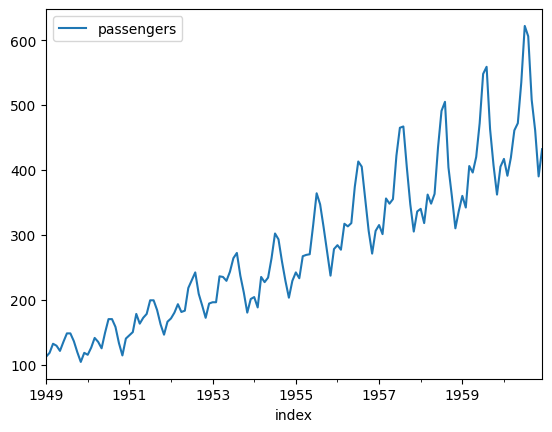

In [27]:
airpass = pd.read_csv(
    "https://raw.githubusercontent.com/pymc-devs/pymc-experimental/main/pymc_experimental/tests/statespace/test_data/airpass.csv",
    parse_dates=True,
    # date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
).rename(columns={"value": "passengers"})
airpass.index.freq = airpass.index.inferred_freq
airpass.plot()

In [28]:
ss_mod = pmss.BayesianSARIMA(
    order=(2, 1, 2), seasonal_order=(2, 0, 2, 12), verbose=True, 
    stationary_initialization=False
)

The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (28,), constraints: None, dims: ('state',)
	P0 -- shape: (28, 28), constraints: Positive Semi-definite, dims: ('state', 'state_aux')
	ar_params -- shape: (2,), constraints: None, dims: ('ar_lag',)
	ma_params -- shape: (2,), constraints: None, dims: ('ma_lag',)
	seasonal_ar_params -- shape: (2,), constraints: None, dims: ('seasonal_ar_lag',)
	seasonal_ma_params -- shape: (2,), constraints: None, dims: ('seasonal_ma_lag',)
	sigma_state -- shape: (1,), constraints: Positive, dims: ('observed_state',)


In [29]:
with pm.Model(coords=ss_mod.coords) as arma_model:
    # State 0 is associated with the observed data, and has a non-zero initial state (because the data has a non-zero intercept)
    intercept = pm.Normal("intercept", mu=4.5, sigma=1, shape=(1,))
    x0 = pm.Deterministic(
        "x0", pt.concatenate([intercept, pt.zeros(ss_mod.k_states - 1)]), dims=["state"]
    )

    # Give State 0 (the non-zero one) it's own sigma for the initial covariance, while all the stationary states can share a single
    # sigma
    sigma_P0 = pm.Gamma("sigma_P0", alpha=2, beta=10, shape=(2,))
    P0 = pt.eye(ss_mod.k_states) * sigma_P0[1]
    P0 = pt.set_subtensor(P0[0, 0], sigma_P0[0])
    P0 = pm.Deterministic("P0", P0, dims=["state", "state_aux"])

    ar_params = pm.Normal("ar_params", mu=0.0, sigma=0.5, dims=ss_mod.param_dims["ar_params"])
    seasonal_ar_params = pm.Normal(
        "seasonal_ar_params", mu=0.0, sigma=0.5, dims=ss_mod.param_dims["seasonal_ar_params"]
    )

    ma_params = pm.Normal("ma_params", mu=0.0, sigma=0.5, dims=ss_mod.param_dims["ma_params"])
    seasonal_ma_params = pm.Normal(
        "seasonal_ma_params", mu=0.0, sigma=0.5, dims=ss_mod.param_dims["seasonal_ma_params"]
    )

    state_sigmas = pm.Gamma("sigma_state", alpha=2, beta=1.0, dims=ss_mod.param_dims["sigma_state"])

    # Remember to log the data by hand
    ss_mod.build_statespace_graph(airpass.apply(np.log), mode="JAX")

    idata = pm.sample(nuts_sampler="numpyro")

Compiling...
Compilation time =  0:00:04.623034
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:10:37.644554
Transforming variables...
Transformation time =  0:01:38.152572


/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


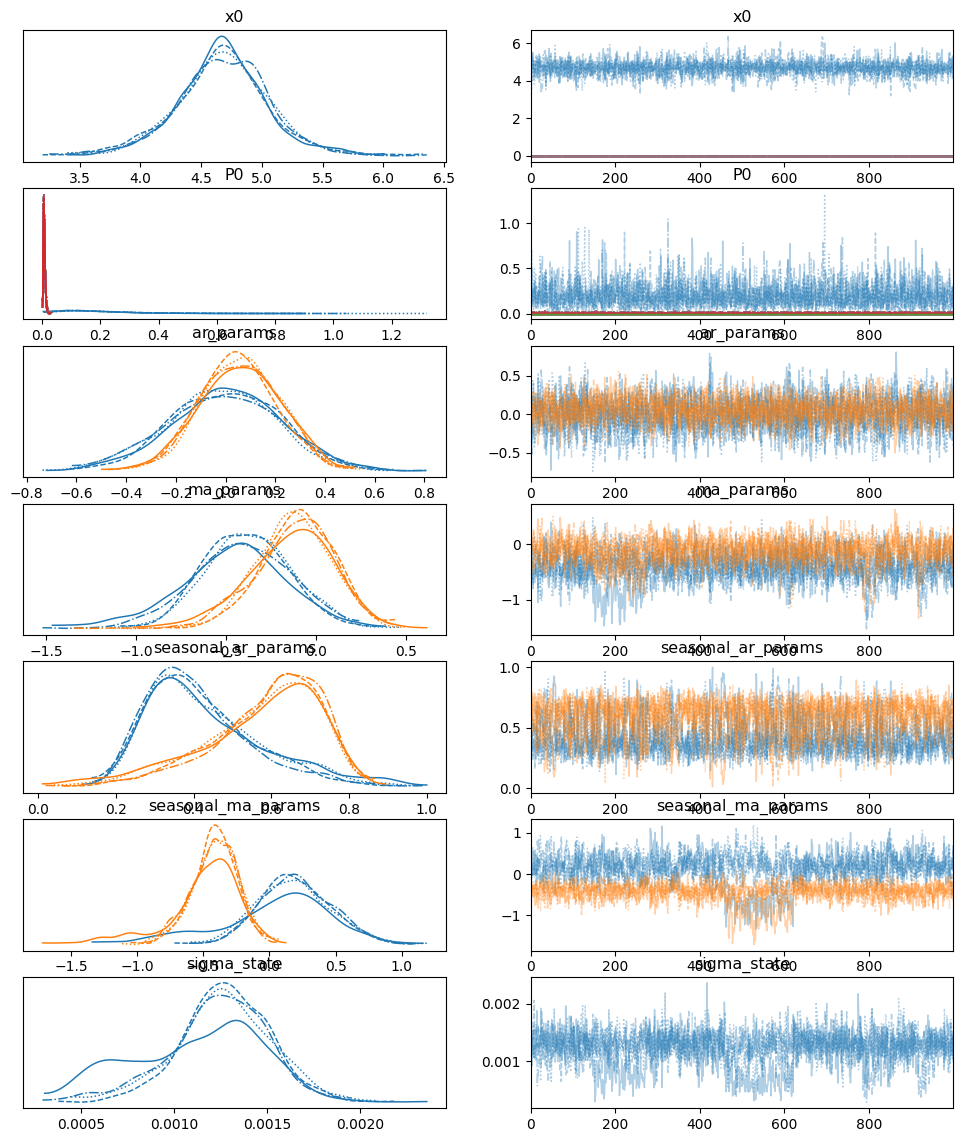

In [30]:
# Let's see the parameter estimates after we pressed the inference button
az.plot_trace(idata, var_names=ss_mod.param_names);

## Conditional Posterior

In [31]:
post_pred = ss_mod.sample_conditional_posterior(idata)

/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x30488A960>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x304808660>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x30495BA00>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x30480A960>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x304958BA0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x304889C40>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


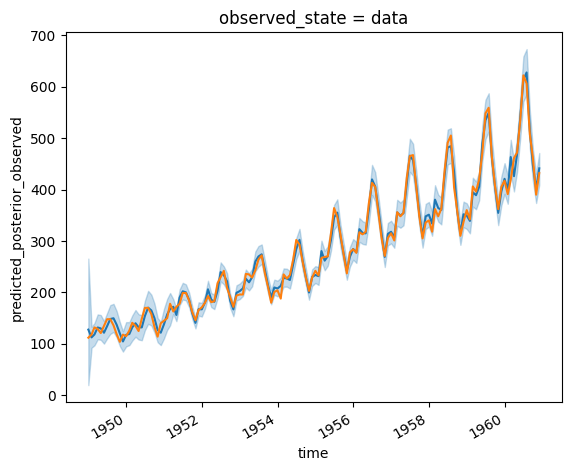

In [32]:
fig, ax = plt.subplots()
post = az.extract(post_pred).map(np.exp)
hdi = az.hdi(post_pred.map(np.exp))[f"predicted_posterior_observed"]
post[f"predicted_posterior_observed"].isel(observed_state=0).mean(dim="sample").plot.line(
    x="time", ax=ax, add_legend=False
)
ax.fill_between(
    hdi.coords["time"], *hdi.isel(observed_state=0).values.T, alpha=0.25, color="tab:blue"
)
ax.plot(airpass.index, airpass.values)
plt.show()

## Forecasts

In [33]:
forecast_idata = ss_mod.forecast(idata, start=airpass.index[-1], periods=20)

/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-cJ-90z5p-py3.10/lib/python3.10/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x3049C2960>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


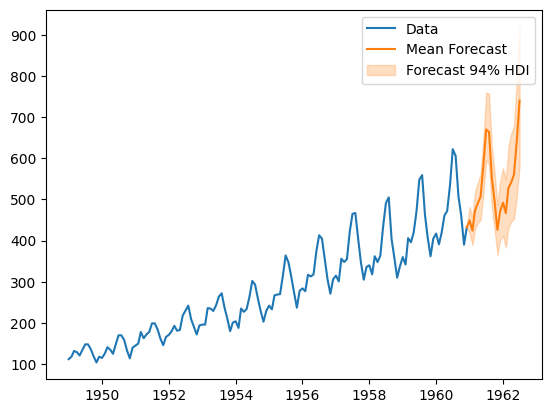

In [34]:
forecast_hdi = az.hdi(forecast_idata.map(np.exp)).forecast_observed.isel(observed_state=0)
forecast_mu = forecast_idata.map(np.exp).forecast_observed.mean(dim=["chain", "draw"])
fig, ax = plt.subplots()
ax.plot(airpass.index, airpass.values, label="Data")
ax.plot(forecast_mu.coords["time"], forecast_mu, label="Mean Forecast")
ax.fill_between(
    forecast_mu.coords["time"],
    *forecast_hdi.values.T,
    label="Forecast 94% HDI",
    color="tab:orange",
    alpha=0.25
)
ax.legend()
plt.show()

## Reference

Since the stuff is so new it's all in `pymc-experimental` as a series of notebooks:

* [Making a Custom Statespace Model](https://github.com/pymc-devs/pymc-experimental/blob/main/notebooks/Making%20a%20Custom%20Statespace%20Model.ipynb)
* [Structural Timeseries Modeling](https://github.com/pymc-devs/pymc-experimental/blob/main/notebooks/Structural%20Timeseries%20Modeling.ipynb)
* [SARMA Example](https://github.com/pymc-devs/pymc-experimental/blob/main/notebooks/SARMA%20Example.ipynb)